In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from sklearn.linear_model import LinearRegression

import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy import stats
from scipy.signal import periodogram
from datetime import timedelta

In [2]:
adcp1 = xr.open_dataset('ADCP/adcp1.nc')
adcp1_5m = xr.open_dataset('ADCP/adcp1_5m.nc')
adcp1_10m = xr.open_dataset('ADCP/adcp1_10m.nc')
adcp1_10mroll = xr.open_dataset('ADCP/adcp1_10mroll.nc')

adcp2 = xr.open_dataset('ADCP/adcp2.nc')
adcp2_1m = xr.open_dataset('ADCP/adcp2_1m.nc')
adcp2_5m = xr.open_dataset('ADCP/adcp2_5m.nc')
adcp2_10m = xr.open_dataset('ADCP/adcp2_10m.nc')
adcp2_10mroll = xr.open_dataset('ADCP/adcp2_10mroll.nc')

temp = xr.open_dataset('Temperature/temp_w_rho.nc')

### Richardson number Ri
- Ri = N^2 / (du/dz)^2
- N^2 = -(g/rho) * (drho/dz)

In [3]:
adcp1

<xarray.Dataset>
Dimensions:         (BinDist: 47, bin: 47, time: 34834)
Coordinates:
    BinDist         (bin) float64 ...
  * time            (time) datetime64[ns] 2022-07-21T10:30:00 ... 2022-08-14T...
Dimensions without coordinates: bin
Data variables:
    Pitch           (time) float64 ...
    Roll            (time) float64 ...
    Heading         (time) float64 ...
    Temperature     (time) float64 ...
    Depth           (time) float64 ...
    Battery         (time) int64 ...
    East            (BinDist, time) float64 ...
    North           (BinDist, time) float64 ...
    Vertical        (BinDist, time) float64 ...
    Magnitude       (BinDist, time) float64 ...
    Direction       (BinDist, time) float64 ...
    Error_velocity  (BinDist, time) float64 ...
    Correlation     (BinDist, time) int64 ...
    PG1             (BinDist, time) int64 ...
    PG4             (BinDist, time) int64 ...
    EA1             (BinDist, time) int64 ...
    EA2             (BinDist, time) int64 ...
    EA3             (BinDist, time) int64 ...
    EA4             (BinDist, time) int64 ...
    Flag            (BinDist, time) float64 ...
Attributes:
    description:          Velocity in beam coordinates
    PingsPerEns:          70
    TimePerPing:          00:00.85
    First Ensemble Date:  22/07/21
    First Ensemble Time:  10:30:00.00
    Ensemble Interval:    60.0
    1st Bin Range:        0.81
    Bin Size:             0.25
    RDI binary file:      C:\Users\tconnolly\Desktop\LG_SWC_Depl\ADCP\SWC0100...
    Instrument:           Broadband 1228.8 kHz

In [4]:
temp

<xarray.Dataset>
Dimensions:      (depth: 7, time: 69761)
Coordinates:
    dcell        (depth) float64 ...
  * time         (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T10:...
Dimensions without coordinates: depth
Data variables:
    Temperature  (depth, time) float64 ...
    Rho          (depth, time) float64 ...
Attributes:
    description:  Temperature of water column over time

In [5]:
# Slice data so the timelines are the same
adcp1_d1 = adcp1.sel(time = slice('2022-07-21T22:39:00.000000000', '2022-08-14T15:03:00.000000000'))
temp_d1 = temp.sel(time = slice('2022-07-21T22:39:00.000000000', '2022-08-14T15:03:00.000000000'))

In [7]:
# Interpolate density over adcp bins
temp_d1.interp(depth = np.array(adcp1.BinDist),method="linear", kwargs={"fill_value": "extrapolate"})


<xarray.Dataset>
Dimensions:      (depth: 47, time: 34105)
Coordinates:
    dcell        (depth) float64 3.62 4.12 4.62 5.12 ... 11.37 11.44 11.52 11.59
  * time         (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-08-14T15:...
Dimensions without coordinates: depth
Data variables:
    Temperature  (depth, time) float64 nan nan nan nan ... 10.98 10.98 10.98
    Rho          (depth, time) float64 nan nan nan nan ... 25.68 25.68 25.68
    depth        (depth) float64 0.81 1.06 1.31 1.56 ... 11.56 11.81 12.06 12.31
Attributes:
    description:  Temperature of water column over time

<ipython-input-11-ad662d3b7a7b>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temp_d1.time, temp_d1.dcell, temp_d1.Rho ,norm=norm)


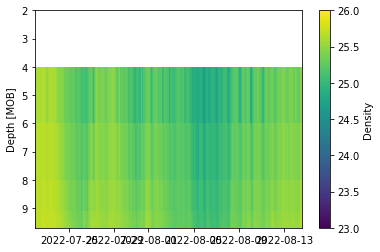

In [11]:
# Current profile
plt.figure()
minvel = 23 # Limits for the colorbars used on the adcp colorplots
maxvel = 26
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)
#plt.title('ADCP Eastern Velocity')
plt.pcolormesh(temp_d1.time, temp_d1.dcell, temp_d1.Rho ,norm=norm)
plt.colorbar(label='Density')
#plt.gca().invert_yaxis()
plt.ylabel('Depth [MOB]')
plt.margins(x=.01)